# ECDF Generator - Polars Only

This notebook uses **Polars exclusively** for the ECDF computation pipeline.

**Features:**
1. Extract ICU time windows from ADT table
2. Filter labs/vitals to values during ICU stays only
3. Standardize lab reference units
4. Compute ECDF (distinct value/probability pairs)
5. Compute quantile bins with auto-extreme-splitting

## Imports and Setup

In [1]:
import json
import yaml
import os
from pathlib import Path
from typing import Dict, List, Any, Tuple, Optional
import polars as pl
import numpy as np
from datetime import datetime

# For notebook: set project root relative to notebook location
PROJECT_ROOT = Path(os.getcwd()).parent.parent
print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/dema/WD/CLIF-TableOne


## Configuration Loading

In [2]:
def load_configs(
    clif_config_path: str = None,
    outlier_config_path: str = None,
    lab_vital_config_path: str = None
) -> Tuple[Dict, Dict, Dict]:
    """
    Load all required configuration files.

    Returns:
        Tuple of (clif_config, outlier_config, lab_vital_config)
    """
    if clif_config_path is None:
        clif_config_path = PROJECT_ROOT / 'config' / 'config.json'
    if outlier_config_path is None:
        outlier_config_path = PROJECT_ROOT / 'modules' / 'ecdf' / 'config' / 'outlier_config.yaml'
    if lab_vital_config_path is None:
        lab_vital_config_path = PROJECT_ROOT / 'modules' / 'ecdf' / 'config' / 'lab_vital_config.yaml'

    with open(clif_config_path, 'r') as f:
        clif_config = json.load(f)

    with open(outlier_config_path, 'r') as f:
        outlier_config = yaml.safe_load(f)

    with open(lab_vital_config_path, 'r') as f:
        lab_vital_config = yaml.safe_load(f)

    return clif_config, outlier_config, lab_vital_config

In [3]:
# Load configurations
clif_config, outlier_config, lab_vital_config = load_configs()

print("CLIF Config:")
print(f"  tables_path: {clif_config.get('tables_path')}")
print(f"  file_type: {clif_config.get('file_type')}")
print()
print(f"Outlier config tables: {list(outlier_config.get('tables', {}).keys())}")
print(f"Lab categories in config: {list(lab_vital_config.get('labs', {}).keys())}")
print(f"Vital categories in config: {list(lab_vital_config.get('vitals', {}).keys())}")

CLIF Config:
  tables_path: /Users/dema/WD/CRI_2018_24/BOX_2.1.0/2.1.0
  file_type: parquet

Outlier config tables: ['adt', 'crrt_therapy', 'hospitalization', 'labs', 'medication_admin_continuous', 'ecmo_mcs', 'patient', 'patient_assessments', 'position', 'respiratory_support', 'vitals']
Lab categories in config: ['albumin', 'alkaline_phosphatase', 'alt', 'ast', 'basophils_percent', 'basophils_absolute', 'bicarbonate', 'bilirubin_conjugated', 'bilirubin_total', 'bilirubin_unconjugated', 'bun', 'calcium_ionized', 'calcium_total', 'chloride', 'crp', 'creatinine', 'eosinophils_percent', 'eosinophils_absolute', 'esr', 'ferritin', 'glucose_fingerstick', 'glucose_serum', 'hemoglobin', 'inr', 'lactate', 'ldh', 'lymphocytes_percent', 'lymphocytes_absolute', 'magnesium', 'monocytes_percent', 'monocytes_absolute', 'neutrophils_absolute', 'neutrophils_percent', 'pco2_arterial', 'pco2_venous', 'ph_arterial', 'ph_venous', 'phosphate', 'platelet_count', 'po2_arterial', 'potassium', 'procalcitonin', 

## Helper Functions

In [4]:
def sanitize_unit_for_filename(unit) -> str:
    """
    Sanitize unit string for use in filename.
    Handles both string and list inputs.
    """
    if unit is None:
        return "unknown"
    
    # Handle list of units
    if isinstance(unit, list):
        unit = '_'.join(str(u) for u in unit if u is not None)
    
    if not unit:
        return "unknown"

    sanitized = unit.replace('/', '_').replace('%', 'pct').replace('°', 'deg')
    sanitized = ''.join(c if c.isalnum() or c == '_' else '_' for c in sanitized)
    while '__' in sanitized:
        sanitized = sanitized.replace('__', '_')
    sanitized = sanitized.strip('_').lower()

    return sanitized

## Lab Standardization (using clifpy)

In [5]:
import clifpy
from clifpy.tables import Labs
print(f"clifpy location: {clifpy.__file__}")

clifpy location: /Users/dema/WD/clifpy/clifpy/__init__.py


In [6]:
def standardize_labs_polars(
    tables_path: str,
    file_type: str,
    output_path: str
) -> None:
    """
    Standardize lab reference units and save as parquet.
    Uses clifpy with Polars LazyFrame input.
    """
    labs_path = os.path.join(tables_path, f'clif_labs.{file_type}')
    print(f"Loading labs from {labs_path}...")

    # Load as Polars LazyFrame
    labs_lazy = pl.scan_parquet(labs_path)
    labs_inst = Labs(data=labs_lazy)
    
    # Standardize (clifpy handles the conversion internally)
    labs_inst.standardize_reference_units(
        save=True, 
        output_directory=str(Path(output_path).parent),
        lowercase=True, 
        inplace=True
    )
    
    # Get the result and save as parquet
    # labs_inst.df should now be standardized
    if isinstance(labs_inst.df, pl.LazyFrame):
        labs_inst.df.collect().write_parquet(output_path)
    elif isinstance(labs_inst.df, pl.DataFrame):
        labs_inst.df.write_parquet(output_path)
    else:
        # Convert from pandas if needed
        pl.from_pandas(labs_inst.df).write_parquet(output_path)
    
    print(f"Saved standardized labs to {output_path}")

In [7]:
# Standardize labs (run once)
STANDARDIZED_LABS_PATH = '../../output/intermediate/clif_labs_standardized_pl.parquet'
os.makedirs(os.path.dirname(STANDARDIZED_LABS_PATH), exist_ok=True)

# Uncomment to run standardization
standardize_labs_polars(
    clif_config['tables_path'],
    clif_config['file_type'],
    STANDARDIZED_LABS_PATH
)

Loading labs from /Users/dema/WD/CRI_2018_24/BOX_2.1.0/2.1.0/clif_labs.parquet...
📢 Initialized labs table
📢 Data directory: .
📢 File type: parquet
📢 Timezone: UTC
📢 Output directory: /Users/dema/WD/CLIF-TableOne/modules/ecdf/output
📢 Loaded schema from /Users/dema/WD/clifpy/clifpy/schemas/labs_schema.yaml
📢 Loaded outlier configuration
📢 Saved unit mappings to ../../output/intermediate/lab_reference_unit_standardized.csv
Saved standardized labs to ../../output/intermediate/clif_labs_standardized_pl.parquet


## ICU Time Window Extraction

In [8]:
def extract_icu_time_windows(
    tables_path: str,
    file_type: str
) -> pl.DataFrame:
    """
    Extract ICU time windows from ADT table using Polars.

    Returns:
        Polars DataFrame with columns:
        - hospitalization_id: str
        - in_dttm: datetime
        - out_dttm: datetime
    """
    adt_path = os.path.join(tables_path, f'clif_adt.{file_type}')
    print(f"Loading ICU time windows from {adt_path}...")

    icu_windows_df = (
        pl.scan_parquet(adt_path)
        .filter(pl.col('location_category').str.to_lowercase() == 'icu')
        .select(['hospitalization_id', 'in_dttm', 'out_dttm'])
        .collect()
        .with_columns([
            pl.col('in_dttm').dt.replace_time_zone(None),
            pl.col('out_dttm').dt.replace_time_zone(None)
        ])
    )

    print(f"Found {len(icu_windows_df):,} ICU time windows")
    return icu_windows_df

In [9]:
# Extract ICU time windows
icu_windows = extract_icu_time_windows(
    clif_config['tables_path'],
    clif_config['file_type']
)

print("\nSample ICU time windows:")
icu_windows.head(10)

Loading ICU time windows from /Users/dema/WD/CRI_2018_24/BOX_2.1.0/2.1.0/clif_adt.parquet...
Found 58,211 ICU time windows

Sample ICU time windows:


hospitalization_id,in_dttm,out_dttm
str,datetime[μs],datetime[μs]
"""632378975""",2022-03-02 22:54:00,2022-03-08 09:21:00
"""632378975""",2022-03-08 18:10:00,2022-03-08 18:11:00
"""632378981""",2020-12-24 05:15:00,2020-12-25 22:01:00
"""632379005""",2018-06-22 21:32:00,2018-06-23 19:51:00
"""632379063""",2021-05-25 06:25:00,2021-05-27 00:58:00
"""632379063""",2021-05-28 20:54:00,2021-05-29 17:52:00
"""632379065""",2021-02-19 23:29:00,2021-02-21 23:35:00
"""632379091""",2021-12-16 09:21:00,2021-12-16 19:05:00
"""632379099""",2020-07-21 21:46:00,2020-07-22 22:38:00


## ECDF Computation (Polars)

In [10]:
def compute_ecdf_polars(values: pl.Series) -> pl.DataFrame:
    """
    Compute ECDF using pure Polars operations.

    Args:
        values: Polars Series of numeric values

    Returns:
        Polars DataFrame with columns:
        - value: float
        - probability: float (0 to 1)
    """
    if len(values) == 0:
        return pl.DataFrame({'value': [], 'probability': []})

    n = len(values)
    
    # Create DataFrame, sort, and compute cumulative probability
    ecdf_df = (
        pl.DataFrame({'value': values})
        .sort('value')
        .with_row_index('rank')
        .with_columns(
            ((pl.col('rank') + 1) / n).alias('probability')
        )
        .group_by('value')
        .agg(pl.col('probability').max())
        .sort('value')
    )

    return ecdf_df

In [11]:
# Test ECDF computation
test_values = pl.Series([1.0, 2.0, 2.0, 3.0, 4.0, 5.0, 5.0, 5.0, 6.0, 7.0])
ecdf_result = compute_ecdf_polars(test_values)

print("Test ECDF computation:")
print(f"Input values: {test_values.to_list()}")
print(f"\nECDF result:")
ecdf_result

Test ECDF computation:
Input values: [1.0, 2.0, 2.0, 3.0, 4.0, 5.0, 5.0, 5.0, 6.0, 7.0]

ECDF result:


value,probability
f64,f64
1.0,0.1
2.0,0.3
3.0,0.4
4.0,0.5
5.0,0.8
6.0,0.9
7.0,1.0


## Binning Functions (Polars)

In [12]:
def create_quantile_bins_polars(
    data: pl.Series,
    num_bins: int = 10
) -> List[Dict[str, Any]]:
    """
    Create quantile bins using Polars.

    Args:
        data: Polars Series with values
        num_bins: Number of bins to create

    Returns:
        List of bin dictionaries
    """
    if len(data) == 0:
        return []

    if len(data) < num_bins * 2:
        num_bins = max(1, len(data) // 2)

    # Calculate quantile edges
    quantiles = [i / num_bins for i in range(num_bins + 1)]
    edges = data.quantile(quantiles)
    
    # Get unique edges to handle duplicates
    edges_list = [data.quantile(q) for q in quantiles]
    
    bins = []
    total_count = len(data)
    
    for i in range(len(edges_list) - 1):
        bin_min = edges_list[i]
        bin_max = edges_list[i + 1]
        
        # Skip duplicate edges
        if bin_min == bin_max and i > 0:
            continue
        
        # Count values in bin
        if i == 0:
            count = data.filter((data >= bin_min) & (data <= bin_max)).len()
        else:
            count = data.filter((data > bin_min) & (data <= bin_max)).len()
        
        if count > 0:
            bins.append({
                'bin_num': len(bins) + 1,
                'bin_min': float(bin_min),
                'bin_max': float(bin_max),
                'count': int(count),
                'percentage': float(count / total_count * 100)
            })

    return bins

In [13]:
def create_bins_for_segment_polars(
    data: pl.Series,
    segment_min: float,
    segment_max: float,
    num_bins: int,
    segment_name: str,
    extra_bins_last: int = 0,
    split_first: bool = False
) -> List[Dict[str, Any]]:
    """
    Create quantile-based bins for a segment using Polars.
    """
    # Filter data to segment range
    segment_data = data.filter((data >= segment_min) & (data <= segment_max))

    if len(segment_data) == 0:
        return []

    if num_bins == 1 or len(segment_data) < num_bins * 2:
        return [{
            'segment': segment_name,
            'bin_num': 1,
            'bin_min': float(segment_data.min()),
            'bin_max': float(segment_data.max()),
            'count': len(segment_data),
            'percentage': 100.0
        }]

    total_segment_count = len(segment_data)
    
    # Calculate quantile edges
    quantiles = [i / num_bins for i in range(num_bins + 1)]
    edges_list = [segment_data.quantile(q) for q in quantiles]
    
    bins = []
    prev_max = None
    
    for i in range(len(edges_list) - 1):
        bin_min = edges_list[i]
        bin_max = edges_list[i + 1]
        
        if bin_min == bin_max and i > 0:
            continue
        
        if i == 0:
            count = segment_data.filter((segment_data >= bin_min) & (segment_data <= bin_max)).len()
        else:
            count = segment_data.filter((segment_data > bin_min) & (segment_data <= bin_max)).len()
        
        if count > 0:
            bins.append({
                'segment': segment_name,
                'bin_num': len(bins) + 1,
                'bin_min': float(bin_min),
                'bin_max': float(bin_max),
                'count': int(count),
                'percentage': float(count / total_segment_count * 100)
            })

    # Handle extra bins for extreme values
    if extra_bins_last > 0 and len(bins) > 0:
        if split_first:
            # Split first bin
            extreme_bin = bins[0]
            extreme_data = segment_data.filter(
                (segment_data >= extreme_bin['bin_min']) & 
                (segment_data <= extreme_bin['bin_max'])
            )
            
            if len(extreme_data) >= extra_bins_last * 2:
                extra_quantiles = [i / extra_bins_last for i in range(extra_bins_last + 1)]
                extra_edges = [extreme_data.quantile(q) for q in extra_quantiles]
                
                new_bins = []
                for j in range(len(extra_edges) - 1):
                    e_min, e_max = extra_edges[j], extra_edges[j + 1]
                    if e_min == e_max and j > 0:
                        continue
                    if j == 0:
                        e_count = extreme_data.filter((extreme_data >= e_min) & (extreme_data <= e_max)).len()
                    else:
                        e_count = extreme_data.filter((extreme_data > e_min) & (extreme_data <= e_max)).len()
                    
                    if e_count > 0:
                        new_bins.append({
                            'segment': segment_name,
                            'bin_num': len(new_bins) + 1,
                            'bin_min': float(e_min),
                            'bin_max': float(e_max),
                            'count': int(e_count),
                            'percentage': float(e_count / total_segment_count * 100)
                        })
                
                # Renumber and combine
                for b in bins[1:]:
                    b['bin_num'] = len(new_bins) + 1
                    new_bins.append(b)
                bins = new_bins
        else:
            # Split last bin
            extreme_bin = bins[-1]
            extreme_data = segment_data.filter(
                (segment_data >= extreme_bin['bin_min']) & 
                (segment_data <= extreme_bin['bin_max'])
            )
            
            if len(extreme_data) >= extra_bins_last * 2:
                extra_quantiles = [i / extra_bins_last for i in range(extra_bins_last + 1)]
                extra_edges = [extreme_data.quantile(q) for q in extra_quantiles]
                
                bins = bins[:-1]  # Remove last bin
                
                for j in range(len(extra_edges) - 1):
                    e_min, e_max = extra_edges[j], extra_edges[j + 1]
                    if e_min == e_max and j > 0:
                        continue
                    if j == 0:
                        e_count = extreme_data.filter((extreme_data >= e_min) & (extreme_data <= e_max)).len()
                    else:
                        e_count = extreme_data.filter((extreme_data > e_min) & (extreme_data <= e_max)).len()
                    
                    if e_count > 0:
                        bins.append({
                            'segment': segment_name,
                            'bin_num': len(bins) + 1,
                            'bin_min': float(e_min),
                            'bin_max': float(e_max),
                            'count': int(e_count),
                            'percentage': float(e_count / total_segment_count * 100)
                        })

    return bins

In [14]:
def create_all_bins_polars(
    data: pl.Series,
    normal_lower: float,
    normal_upper: float,
    outlier_min: float,
    outlier_max: float,
    bins_below: int,
    bins_normal: int,
    bins_above: int,
    extra_bins_below: int = 0,
    extra_bins_above: int = 0
) -> List[Dict[str, Any]]:
    """
    Create bins for all segments using Polars.
    """
    all_bins = []

    # Below normal segment
    if bins_below > 0 and outlier_min < normal_lower:
        below_bins = create_bins_for_segment_polars(
            data, outlier_min, normal_lower, bins_below, 'below',
            extra_bins_last=extra_bins_below,
            split_first=True
        )
        all_bins.extend(below_bins)

    # Normal segment
    if bins_normal > 0:
        normal_bins = create_bins_for_segment_polars(
            data, normal_lower, normal_upper, bins_normal, 'normal'
        )
        all_bins.extend(normal_bins)

    # Above normal segment
    if bins_above > 0 and normal_upper < outlier_max:
        above_bins = create_bins_for_segment_polars(
            data, normal_upper, outlier_max, bins_above, 'above',
            extra_bins_last=extra_bins_above,
            split_first=False
        )
        all_bins.extend(above_bins)

    return all_bins

In [15]:
# Test binning
np.random.seed(42)
test_values = pl.Series(np.random.randn(10000) * 20 + 100)

bins = create_all_bins_polars(
    data=test_values,
    normal_lower=80,
    normal_upper=120,
    outlier_min=0,
    outlier_max=200,
    bins_below=3,
    bins_normal=4,
    bins_above=3,
    extra_bins_below=5,
    extra_bins_above=5
)

print(f"Created {len(bins)} bins:")
for b in bins:
    print(f"  Bin {b['bin_num']:2d}: [{b['bin_min']:8.2f}, {b['bin_max']:8.2f}] - "
          f"segment: {b['segment']:10s}, count: {b['count']:5d}, pct: {b['percentage']:5.1f}%")

Created 18 bins:
  Bin  1: [   21.55,    54.08] - segment: below     , count:   107, pct:   6.7%
  Bin  2: [   54.08,    59.22] - segment: below     , count:   106, pct:   6.7%
  Bin  3: [   59.22,    62.54] - segment: below     , count:   105, pct:   6.6%
  Bin  4: [   62.54,    65.07] - segment: below     , count:   106, pct:   6.7%
  Bin  5: [   65.07,    67.73] - segment: below     , count:   106, pct:   6.7%
  Bin  6: [   67.73,    74.91] - segment: below     , count:   528, pct:  33.3%
  Bin  7: [   74.91,    79.99] - segment: below     , count:   529, pct:  33.3%
  Bin  1: [   80.01,    91.04] - segment: normal    , count:  1706, pct:  25.0%
  Bin  2: [   91.04,    99.93] - segment: normal    , count:  1705, pct:  25.0%
  Bin  3: [   99.93,   108.71] - segment: normal    , count:  1704, pct:  25.0%
  Bin  4: [  108.71,   119.97] - segment: normal    , count:  1705, pct:  25.0%
  Bin  1: [  120.01,   124.99] - segment: above     , count:   532, pct:  33.4%
  Bin  2: [  124.99,   

## Process Single Category (Labs/Vitals)

In [16]:
def process_category_polars(
    table_type: str,
    category: str,
    unit: Optional[str],
    icu_windows: pl.DataFrame,
    tables_path: str,
    file_type: str,
    outlier_range: Dict[str, float],
    cat_config: Dict[str, Any],
    output_dir: str = None,
    extreme_bins_count: int = 5,
    save_output: bool = False
) -> Tuple[Dict[str, Any], pl.DataFrame, pl.DataFrame]:
    """
    Process a single lab/vital category using pure Polars.
    """
    # Determine file path and column names
    if table_type == 'labs':
        file_path = '../../output/intermediate/clif_labs_standardized_pl.parquet'
        category_col = 'lab_category'
        value_col = 'lab_value_numeric'
        datetime_col = 'lab_result_dttm'
    else:  # vitals
        file_path = os.path.join(tables_path, f'clif_vitals.{file_type}')
        category_col = 'vital_category'
        value_col = 'vital_value'
        datetime_col = 'recorded_dttm'

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Data file not found: {file_path}")

    display_name = f"{category} ({unit})" if table_type == 'labs' and unit else category
    print(f"Loading {display_name}...")

    # Build filter for category and unit
    data_lazy = pl.scan_parquet(file_path)
    
    if table_type == 'labs' and unit:
        if isinstance(unit, list):
            unit_filter = pl.col('reference_unit').is_in(unit)
        else:
            unit_filter = pl.col('reference_unit') == unit
        
        data_category = data_lazy.filter(
            (pl.col(category_col) == category) & unit_filter
        ).select(['hospitalization_id', datetime_col, value_col])
    else:
        data_category = data_lazy.filter(
            pl.col(category_col) == category
        ).select(['hospitalization_id', datetime_col, value_col])

    # Join with ICU time windows and filter to ICU stay times
    values_df = (
        data_category
        .join(icu_windows.lazy(), on='hospitalization_id', how='inner')
        .filter(
            (pl.col(datetime_col).dt.replace_time_zone(None) >= pl.col('in_dttm')) &
            (pl.col(datetime_col).dt.replace_time_zone(None) <= pl.col('out_dttm'))
        )
        .select([value_col])
        .collect()
    )

    original_count = len(values_df)
    print(f"  Original count: {original_count:,}")

    if original_count == 0:
        print(f"  WARNING: No data found for {display_name} during ICU stays")
        return (
            {'category': category, 'unit': unit, 'original_count': 0, 'clean_count': 0},
            pl.DataFrame({'value': [], 'probability': []}),
            pl.DataFrame()
        )

    # Remove outliers
    values_clean = values_df.filter(
        (pl.col(value_col) >= outlier_range['min']) &
        (pl.col(value_col) <= outlier_range['max'])
    )

    clean_count = len(values_clean)
    print(f"  After outlier removal: {clean_count:,} (removed {original_count - clean_count:,})")

    if clean_count == 0:
        print(f"  WARNING: No data remaining after outlier removal")
        return (
            {'category': category, 'unit': unit, 'original_count': original_count, 'clean_count': 0},
            pl.DataFrame({'value': [], 'probability': []}),
            pl.DataFrame()
        )

    # Get values as Polars Series
    values_series = values_clean[value_col]

    # Compute ECDF
    ecdf_df = compute_ecdf_polars(values_series)
    print(f"  ECDF: {len(ecdf_df):,} distinct pairs (compression: {clean_count / len(ecdf_df):.1f}x)")

    # Compute Bins
    bins_below = cat_config['bins']['below_normal']
    bins_normal = cat_config['bins']['normal']
    bins_above = cat_config['bins']['above_normal']

    extra_bins_below = extreme_bins_count if bins_below > 1 else 0
    extra_bins_above = extreme_bins_count if bins_above > 1 else 0

    bins = create_all_bins_polars(
        data=values_series,
        normal_lower=cat_config['normal_range']['lower'],
        normal_upper=cat_config['normal_range']['upper'],
        outlier_min=outlier_range['min'],
        outlier_max=outlier_range['max'],
        bins_below=bins_below,
        bins_normal=bins_normal,
        bins_above=bins_above,
        extra_bins_below=extra_bins_below,
        extra_bins_above=extra_bins_above
    )

    # Add interval notation
    for bin_info in bins:
        if bin_info['bin_num'] == 1:
            interval = f"[{bin_info['bin_min']:.2f}, {bin_info['bin_max']:.2f}]"
        else:
            interval = f"({bin_info['bin_min']:.2f}, {bin_info['bin_max']:.2f}]"
        bin_info['interval'] = interval

    bins_df = pl.DataFrame(bins) if bins else pl.DataFrame()
    print(f"  Bins: {len(bins_df)}")

    # Save output
    if save_output and output_dir:
        if table_type == 'labs' and unit:
            unit_for_filename = unit[0] if isinstance(unit, list) else unit
            unit_safe = sanitize_unit_for_filename(unit_for_filename)
            filename = f'{category}_{unit_safe}.parquet'
        else:
            filename = f'{category}.parquet'

        ecdf_dir = os.path.join(output_dir, 'ecdf', table_type)
        os.makedirs(ecdf_dir, exist_ok=True)
        ecdf_df.write_parquet(os.path.join(ecdf_dir, filename))

        bins_dir = os.path.join(output_dir, 'bins', table_type)
        os.makedirs(bins_dir, exist_ok=True)
        bins_df.write_parquet(os.path.join(bins_dir, filename))

        print(f"  Saved to {output_dir}")

    stats = {
        'category': category,
        'unit': unit if table_type == 'labs' else None,
        'original_count': original_count,
        'clean_count': clean_count,
        'ecdf_distinct_pairs': len(ecdf_df),
        'num_bins': len(bins)
    }

    return stats, ecdf_df, bins_df

## Test: Process a Single Lab Category

In [17]:
labs_config = lab_vital_config.get('labs', {})
labs_outlier = outlier_config['tables']['labs']['lab_value_numeric']

print("Available lab categories in config:")
for cat in sorted(labs_config.keys()):
    if isinstance(labs_config.get(cat), dict):
        in_outlier = cat in labs_outlier
        print(f"  {cat}: outlier config = {in_outlier}")

Available lab categories in config:
  albumin: outlier config = True
  alkaline_phosphatase: outlier config = True
  alt: outlier config = True
  ast: outlier config = True
  basophils_absolute: outlier config = True
  basophils_percent: outlier config = True
  bicarbonate: outlier config = True
  bilirubin_conjugated: outlier config = True
  bilirubin_total: outlier config = True
  bilirubin_unconjugated: outlier config = True
  bun: outlier config = True
  calcium_ionized: outlier config = True
  calcium_total: outlier config = True
  chloride: outlier config = True
  creatinine: outlier config = True
  crp: outlier config = True
  eosinophils_absolute: outlier config = True
  eosinophils_percent: outlier config = True
  esr: outlier config = True
  ferritin: outlier config = True
  glucose_fingerstick: outlier config = True
  glucose_serum: outlier config = True
  hemoglobin: outlier config = True
  inr: outlier config = True
  lactate: outlier config = True
  ldh: outlier config = 

In [18]:
TEST_LAB_CATEGORY = 'albumin'

if TEST_LAB_CATEGORY in labs_config and TEST_LAB_CATEGORY in labs_outlier:
    cat_config = labs_config[TEST_LAB_CATEGORY]
    if cat_config and isinstance(cat_config, dict):
        test_unit = cat_config.get('reference_unit')
        if isinstance(test_unit, str):
            test_unit = test_unit.lower()
        elif isinstance(test_unit, list):
            test_unit = [u.lower() if isinstance(u, str) else u for u in test_unit]
        
        stats, ecdf_df, bins_df = process_category_polars(
            table_type='labs',
            category=TEST_LAB_CATEGORY,
            unit=test_unit,
            icu_windows=icu_windows,
            tables_path=clif_config['tables_path'],
            file_type=clif_config['file_type'],
            outlier_range=labs_outlier[TEST_LAB_CATEGORY],
            cat_config=cat_config,
            extreme_bins_count=5,
            save_output=False
        )
        
        print(f"\nStats: {stats}")
else:
    print(f"Category '{TEST_LAB_CATEGORY}' not found in config")

Loading albumin (['g/dl'])...
  Original count: 144,122
  After outlier removal: 144,090 (removed 32)
  ECDF: 62 distinct pairs (compression: 2324.0x)
  Bins: 14

Stats: {'category': 'albumin', 'unit': ['g/dl'], 'original_count': 144122, 'clean_count': 144090, 'ecdf_distinct_pairs': 62, 'num_bins': 14}


In [19]:
print("ECDF (first 20 rows):")
ecdf_df.head(20)

ECDF (first 20 rows):


value,probability
f64,f64
0.2,0.000014
0.3,0.000028
0.4,0.00009
0.5,0.000132
0.6,0.000257
…,…
1.7,0.041682
1.8,0.058283
1.9,0.080179


In [20]:
print("Bins:")
bins_df

Bins:


segment,bin_num,bin_min,bin_max,count,percentage,interval
str,i64,f64,f64,i64,f64,str
"""below""",1,0.2,1.7,6006,4.997046,"""[0.20, 1.70]"""
"""below""",2,1.7,1.9,5547,4.615154,"""(1.70, 1.90]"""
"""below""",3,1.9,2.0,3800,3.161634,"""(1.90, 2.00]"""
"""below""",4,2.0,2.2,10123,8.422428,"""(2.00, 2.20]"""
"""below""",5,2.2,2.6,28346,23.584129,"""(2.20, 2.60]"""
…,…,…,…,…,…,…
"""normal""",2,3.6,3.7,4164,14.177732,"""(3.60, 3.70]"""
"""normal""",3,3.7,3.8,3558,12.114402,"""(3.70, 3.80]"""
"""normal""",4,3.8,4.0,5414,18.433776,"""(3.80, 4.00]"""


## Test: Process a Single Vital Category

In [21]:
vitals_config = lab_vital_config.get('vitals', {})
vitals_outlier = outlier_config['tables']['vitals']['vital_value']

TEST_VITAL_CATEGORY = 'heart_rate'

if TEST_VITAL_CATEGORY in vitals_config and TEST_VITAL_CATEGORY in vitals_outlier:
    extreme_bins = 5 if TEST_VITAL_CATEGORY in ['height_cm', 'weight_kg'] else 10
    
    vital_stats, vital_ecdf_df, vital_bins_df = process_category_polars(
        table_type='vitals',
        category=TEST_VITAL_CATEGORY,
        unit=None,
        icu_windows=icu_windows,
        tables_path=clif_config['tables_path'],
        file_type=clif_config['file_type'],
        outlier_range=vitals_outlier[TEST_VITAL_CATEGORY],
        cat_config=vitals_config[TEST_VITAL_CATEGORY],
        extreme_bins_count=extreme_bins,
        save_output=False
    )
    
    print(f"\nStats: {vital_stats}")
else:
    print(f"Category '{TEST_VITAL_CATEGORY}' not found in config")

Loading heart_rate...
  Original count: 6,650,909
  After outlier removal: 6,650,890 (removed 19)
  ECDF: 280 distinct pairs (compression: 23753.2x)
  Bins: 31

Stats: {'category': 'heart_rate', 'unit': None, 'original_count': 6650909, 'clean_count': 6650890, 'ecdf_distinct_pairs': 280, 'num_bins': 31}


## Visualize ECDF

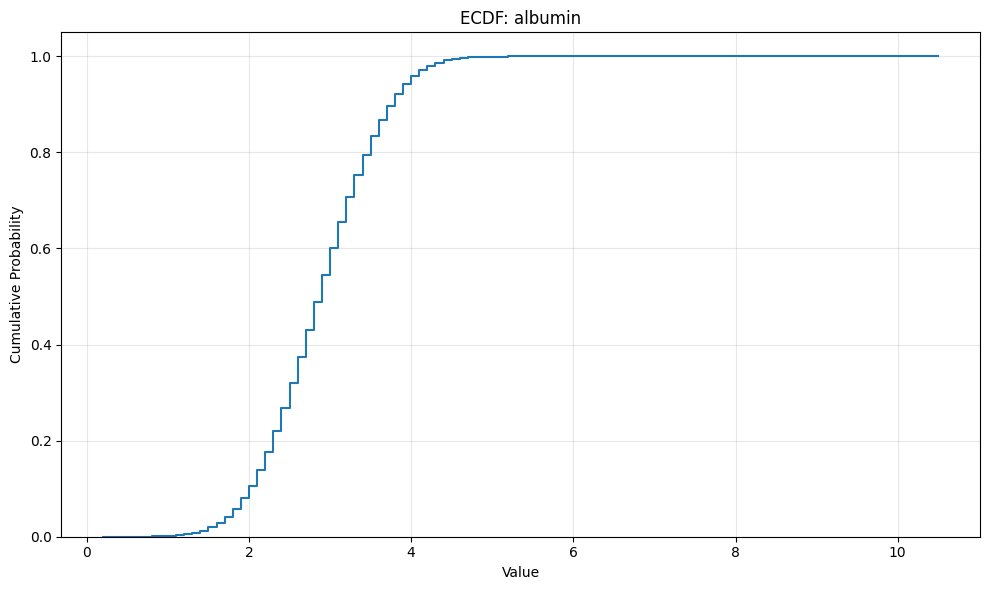

In [22]:
import matplotlib.pyplot as plt

def plot_ecdf(ecdf_df: pl.DataFrame, title: str = "ECDF"):
    """Plot ECDF from a Polars DataFrame."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    values = ecdf_df['value'].to_numpy()
    probs = ecdf_df['probability'].to_numpy()
    
    ax.step(values, probs, where='post', linewidth=1.5)
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.show()

if 'ecdf_df' in dir() and len(ecdf_df) > 0:
    plot_ecdf(ecdf_df, f"ECDF: {TEST_LAB_CATEGORY}")

## Run Full Pipeline

In [23]:
OUTPUT_DIR = str(PROJECT_ROOT / 'output' / 'final')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Process all labs from config
for category, cat_config in labs_config.items():
    if cat_config is None:
        print(f"WARNING: Category '{category}' has None config, skipping")
        continue

    if not isinstance(cat_config, dict):
        continue

    if category not in labs_outlier:
        print(f"WARNING: Category '{category}' not in outlier config, skipping")
        continue

    config_unit = cat_config.get('reference_unit')
    if config_unit is None:
        print(f"WARNING: Category '{category}' has no reference_unit in config, skipping")
        continue

    # Lowercase to match standardized data
    if isinstance(config_unit, str):
        unit = config_unit.lower()
    elif isinstance(config_unit, list):
        unit = [u.lower() if isinstance(u, str) else u for u in config_unit]
    else:
        unit = config_unit

    stats, ecdf_df, bins_df = process_category_polars(
        table_type='labs',
        category=category,
        unit=unit,
        icu_windows=icu_windows,
        tables_path=clif_config['tables_path'],
        file_type=clif_config['file_type'],
        outlier_range=labs_outlier[category],
        cat_config=cat_config,
        output_dir=OUTPUT_DIR,
        extreme_bins_count=5,
        save_output=True
    )

Loading albumin (['g/dl'])...
  Original count: 144,122
  After outlier removal: 144,090 (removed 32)
  ECDF: 62 distinct pairs (compression: 2324.0x)
  Bins: 14
  Saved to /Users/dema/WD/CLIF-TableOne/output/final
Loading alkaline_phosphatase (['u/l', 'u/l', 'iu/l', '[iu]/l'])...
  Original count: 127,700
  After outlier removal: 127,666 (removed 34)
  ECDF: 1,615 distinct pairs (compression: 79.1x)
  Bins: 15
  Saved to /Users/dema/WD/CLIF-TableOne/output/final
Loading alt (['u/l', 'u/l', 'iu/l', '[iu]/l'])...
  Original count: 128,358
  After outlier removal: 128,327 (removed 31)
  ECDF: 3,378 distinct pairs (compression: 38.0x)
  Bins: 15
  Saved to /Users/dema/WD/CLIF-TableOne/output/final
Loading ast (['u/l', 'u/l', 'iu/l', '[iu]/l'])...
  Original count: 126,411
  After outlier removal: 126,333 (removed 78)
  ECDF: 4,407 distinct pairs (compression: 28.7x)
  Bins: 15
  Saved to /Users/dema/WD/CLIF-TableOne/output/final
Loading basophils_percent (%)...
  Original count: 48,871
  

TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [ ]:
# After running both notebooks, compare outputs
import polars as pl
import pandas as pd

# Load outputs
ecdf_polars = pl.read_parquet('output/final/ecdf/labs_polars/albumin_g_dl.parquet')
ecdf_pandas = pd.read_parquet('output/final/ecdf/labs/albumin_g_dl.parquet')

# Compare
print(f"Polars rows: {len(ecdf_polars)}, Pandas rows: 
{len(ecdf_pandas)}")
print(f"Max probability diff: 
{abs(ecdf_polars['probability'].to_numpy() - 
ecdf_pandas['probability'].values).max()}")